# Regularization



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import cross_validation

%matplotlib inline

## OLS vs. Ridge vs. LASSO

The usage of ridge and lasso regressions are very similar to the linear regressions. To motivate the initial usage of these models, we are going to create a high degree dataset first.

In [4]:
def quadFunc(x): return 1 + .1*(x-4) ** 2

def noiseFunc(x): return (np.random.random(len(x))-0.5)

def noisyQuad(x): return quadFunc(x) + noiseFunc(x)

In [5]:
domain = np.linspace(0,10,1000)
y_true = quadFunc(domain)

x_sample = np.sort(np.random.choice(domain,10))
y_sample = noisyQuad(x_sample)

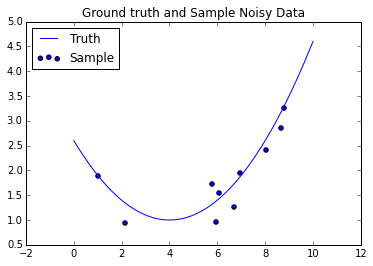

In [6]:
plt.plot(domain,quadFunc(domain),label="Truth")
plt.scatter(x_sample,y_sample,label="Sample")
plt.legend(loc='upper left')
plt.title("Ground truth and Sample Noisy Data")

Without seeing the ground truth line, we might believe that there is certainly some degree of polynomial effects here. Instead of the janky way of manually creating polynomials, we are going to use sklearn pipeline to create a 'model pipeline' using the PolynomialFeatures transformations.


[Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) Let's you set up a pipeline of transformations, model building, etc.

[Preprocessing](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) Will use the PolynomialFeatures within Preprocessing)

[Metrics](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) Provides other scoring mechanisms, we will use the mean squared error

In [7]:
from sklearn import preprocessing
from sklearn import pipeline

from sklearn import metrics

### OLS Solution

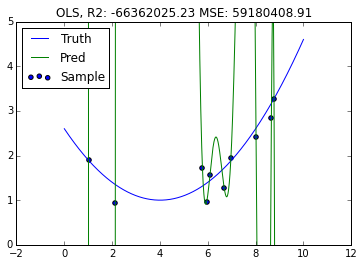

In [8]:
X = np.array([x_sample]).T # Reshape x_sample into a matrix

pf = preprocessing.PolynomialFeatures(degree=20)
std = preprocessing.StandardScaler()
model = pipeline.make_pipeline(pf,std,linear_model.LinearRegression())
model.fit(X,y_sample)

#Now predict over our domain so we can plot it
y_pred = model.predict( np.array([domain]).T )
r2_score = model.score(np.array([domain]).T,y_true)
mse_score = metrics.mean_squared_error(y_true,y_pred)

#Plot the ground truth, data points, and our predictions over the domain
plt.plot(domain,y_true,label="Truth")
plt.scatter(x_sample,y_sample,label="Sample")
plt.plot(domain,y_pred,label="Pred")
plt.title("OLS, R2: %.2f MSE: %.2f" % (r2_score, mse_score))
plt.xlim(-2,12), plt.ylim(0,5)
plt.legend(loc="upper left")

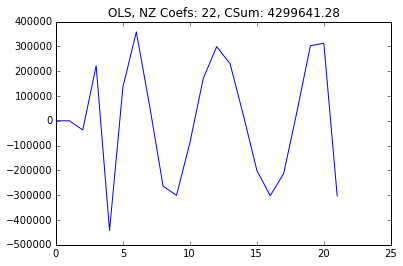

In [9]:
# OLS Coefficient Diagnostics

#Each step of the 'pipeline' model is saved as a list of tuples
model.steps

coefs = model.steps[2][1].coef_
coefs = np.insert(coefs,0,model.steps[2][1].intercept_)
nz    = np.sum( coefs != 0 )
csum  = np.sum( np.abs( coefs ) )

plt.plot(coefs)
plt.title("OLS, NZ Coefs: %d, CSum: %.2f"% (nz,csum))

### Ridge Solution

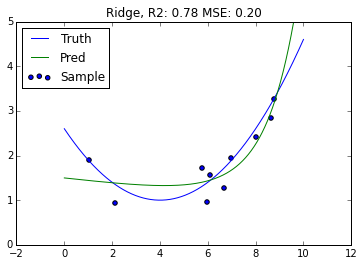

In [10]:
X = np.array([x_sample]).T # Reshape x_sample into a matrix

pf = preprocessing.PolynomialFeatures(degree=20)
std = preprocessing.StandardScaler()
model = pipeline.make_pipeline(pf,std,linear_model.Ridge(alpha=1.0))
model.fit(X,y_sample)

#Now predict over our domain so we can plot it
y_pred = model.predict( np.array([domain]).T )

r2_score = model.score(np.array([domain]).T,y_true)
mse_score = metrics.mean_squared_error(y_true,y_pred)


plt.plot(domain,y_true,label="Truth")
plt.scatter(x_sample,y_sample,label="Sample")
plt.plot(domain,y_pred,label="Pred")
plt.xlim(-2,12), plt.ylim(0,5)
plt.title("Ridge, R2: %.2f MSE: %.2f" % (r2_score, mse_score))
plt.legend(loc="upper left")

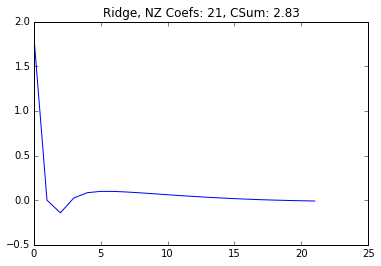

In [11]:
# Ridge Coefficient Diagnostics

coefs = model.steps[2][1].coef_
coefs = np.insert(coefs,0,model.steps[2][1].intercept_)
nz    = np.sum( coefs != 0 )
csum  = np.sum( np.abs( coefs ) )

plt.plot(coefs)
plt.title("Ridge, NZ Coefs: %d, CSum: %.2f"% (nz,csum))

### LASSO Solution

/Users/brianchung/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


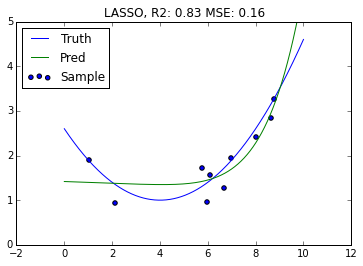

In [12]:
X = np.array([x_sample]).T # Reshape x_sample into a matrix

pf = preprocessing.PolynomialFeatures(degree=20)
std = preprocessing.StandardScaler()
model = pipeline.make_pipeline(pf,std,linear_model.Lasso(alpha=.02))
model.fit(X,y_sample)

#Now predict over our domain so we can plot it
y_pred = model.predict( np.array([domain]).T )

r2_score = model.score(np.array([domain]).T,y_true)
mse_score = metrics.mean_squared_error(y_true,y_pred)

plt.plot(domain,y_true,label="Truth")
plt.scatter(x_sample,y_sample,label="Sample")
plt.plot(domain,y_pred,label="Pred")
plt.xlim(-2,12), plt.ylim(0,5)
plt.title("LASSO, R2: %.2f MSE: %.2f" % (r2_score, mse_score))
plt.legend(loc="upper left")

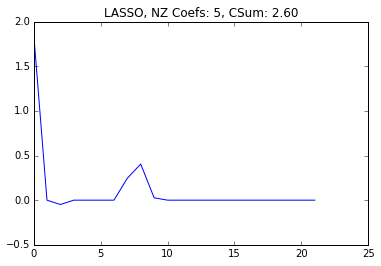

In [13]:
# LASSOCoefficient Diagnostics

coefs = model.steps[2][1].coef_
coefs = np.insert(coefs,0,model.steps[2][1].intercept_)
nz    = np.sum(coefs != 0 )
csum  = np.sum( np.abs( coefs ) )


plt.plot(coefs)
plt.title("LASSO, NZ Coefs: %d, CSum: %.2f"% (nz, csum))

**Holy, Ridge and LASSO regression perform much better than OLS when data is sparse.**

As you can see, for the examples, both Ridge and LASSO have similar 'complexity' in terms of beta sums, but LASSO ALSO zeroed out many of these coefficients. This is automatic feature selection--you can describe your model with far fewer features than you need to with Ridge.

There's a few issues though. For one, I had to remember to preprocess the data to standardize the features so that each coefficient can be on the same "scale" when reducing.

I've manually chosen the hyperparameter--in this case, "alpha", which controls the amount of reduction in beta sizes.

Ideally, we want to automatically choose the hyperparameters through cross validation.

## LASSO / Ridge Cross Validation

The LassoCV() and RidgeCV() classes automatically choose the best lambda/alpha value for you through cross validation.

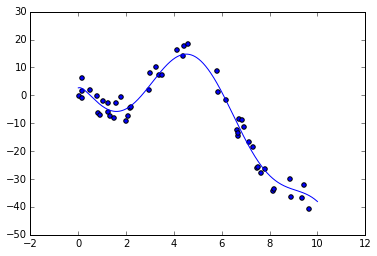

In [14]:
# Create the space of predictions as well as generate a few samples
def quadFunc(x): return 1 + .5*(x-4) ** 2 - 12.0*np.sin(x) + 4*np.log(x+.2) - .1*(x-1)**3

def noiseFunc(x): return (10.0*(np.random.random(len(x))-0.5))

def noisyQuad(x): return quadFunc(x) + noiseFunc(x)

# Create the "True" function
domain = np.linspace(0,10,1000)
y_true = quadFunc(domain)

# Generate points using a noisy version of the function
x_sample = np.sort(np.random.choice(domain,50))
y_sample = noisyQuad(x_sample)

# Plot the points vs truth
plt.plot(domain,y_true)
plt.scatter(x_sample,y_sample)

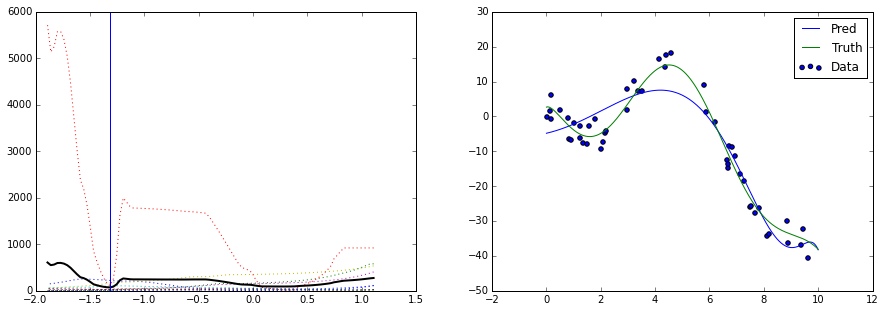

In [15]:
X = np.array([x_sample]).T
X_test = np.array([domain]).T


pf = preprocessing.PolynomialFeatures(degree=20)
std = preprocessing.StandardScaler()
model = pipeline.make_pipeline(pf,std,linear_model.LassoCV(cv=10))
model.fit(X,y_sample)

alphas   = model.steps[2][1].alphas_
alpha    = model.steps[2][1].alpha_
mse_path = model.steps[2][1].mse_path_

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.log10(alphas), mse_path,":")
plt.plot(np.log10(alphas), np.mean(mse_path,axis=-1),'k',linewidth=2)
plt.axvline(np.log10(alpha))

plt.subplot(1,2,2)
plt.plot(domain, model.predict(X_test),label="Pred")
plt.plot(domain, y_true,label="Truth")
plt.scatter(x_sample,y_sample,label="Data")
plt.legend()

Notice how noisy each individual path is! 

## Exercise

In this exercise, we will be comparing OLS vs Ridge vs LASSO for the purpose of stock return prediction. The data is scaled down from a popular, currently ongoing Kaggle Competition

Using feature_x where x is between 1 and 25, as well as Ret_MinusOne (return day minus one), and Ret_MinusTwo (return day minus two), try to predict the next day's return, Ret_PlusOne.

**Helpful Notes**

* Try using the return features as well as non-integer features at first. They make no mention of whether features such as Feature_5, Feature_9, Feature_10 are categorical or if they are ordered (perhaps deciles).
* Use the cross_validation_score module from sklearn to run cross validation with cv=KFold [Link](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html). Choose shuffle=True in order to shuffle the rows for cross validation
* Try winsorizing the features as well as response variable! If you plot a histogram of our response variable, Ret_PlusOne, for instance, you will see that there are a few outliers that really screw up the histogram. Trying to fit OLS on these outliers for instance will bias our results (remember that OLS: min (y - y_pred)^2 )
* Lastly, **ask questions!** This exercise is very free form--it is meant to force you to write code and for you to find out what you understand and what you don't.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import cross_validation

%matplotlib inline

In [67]:
path_to_repo = "/Users/brianchung/Desktop/ga-ds/"
data = pd.read_csv(path_to_repo + "/06_regularization/train.csv")
data.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Ret_MinusOne,Ret_MinusTwo,Ret_PlusOne
0,NaN,0.459215,-0.826491,-0.864517,8,-0.535783,12790,0.0111,5,NaN,...,0.009563,NaN,-1.136495,1.672557,-0.036065,0.227910,-0.098006,-0.011596,-0.017491,-0.002829
1,3,0.920454,0.609907,0.403159,7,0.567136,30391,0.0100,10,NaN,...,-1.312337,6,0.636846,0.498178,1.374641,0.332358,-0.586665,0.007333,-0.001130,0.004491
2,NaN,-1.476290,0.765779,NaN,1,0.559726,10741,0.3650,11,NaN,...,-1.233831,2,2.830402,0.057682,0.982588,-3.334727,2.557301,0.018327,0.012910,-0.021215
3,3,-0.854041,1.475377,1.393103,7,1.234066,39455,0.0166,13,1,...,-1.976143,5,1.956040,0.427805,1.652732,-1.295203,-1.107801,0.009980,-0.002534,-0.006631
4,NaN,-1.212389,1.043638,0.742456,8,0.352432,99861,0.3451,8,5,...,-1.680094,6,0.688954,-1.497683,1.391390,-1.909847,-0.963027,0.020058,0.004248,0.008354
